# User defined loss functions

Here we will show how you can define your own loss functions to train a neural network.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import easysurrogate as es

In [2]:
plt.rcParams['image.cmap'] = 'seismic'

We will use a very simple analytic function `f` to generate some training data

In [3]:
def f(x1, x2):
    """
    A simple analytic function.

    Parameters
    ----------
    x1 : float or array of floats
        First input.
    x2 : float or array of floats
        Second input.

    Returns
    -------
    float or array of floats
        Function values at (x1, x2).

    """
    return np.array([np.sin(x1 ** 2) * np.cos(x2), np.cos(x2)])

Generate the training data

In [4]:
n_train = 10000
X = np.random.rand(n_train, 2)
y = f(X[:, 0], X[:, 1]).T
n_out = y.shape[1]

### Squared loss and its dimensions

Here we train a standard ANN with the squared (scalar) loss function (`loss="squared"`):

\begin{align}
L = \frac{1}{n_{out}}\sum_{j=1}^{n_{out}}(y_j - h_j)^2 \in\mathbb{R}
\end{align}

Here, $y_j$ and $h_j$ are the j-th data point and ANN predictions of the j-th neuron, with $j=1,\cdots,n_{out}$. Hence their dimensions are:

Internally, the following gradient is computed:

\begin{align}
\frac{\partial L}{\partial {\bf h}} = -\frac{2}{n_{out}}({\bf y} - {\bf h})\in\mathbb{R}^{n_{out}\times 1}
\end{align}

Note that here;
* ${\bf y} = [y_1,\cdots,y_{n_{out}}]^T\in\mathbb{R}^{n_{out}\times 1}$ and,
* ${\bf h}= [h_1,\cdots,h_{n_{out}}]^T\in\mathbb{R}^{n_{out}\times 1}$

are the full data vector and ANN prediction, respectively. Note that this is the **loss gradient per output neuron**, which is then used to backpropagate the loss backwards through the network.

If `batch_size` > 1 , the process is done simultaneously for each mini batch sample, such that the dimensions change:

\begin{align}
\frac{\partial L}{\partial H} = -\frac{2}{n_{out}}(Y - H)\in\mathbb{R}^{n_{out}\times B}
\end{align}

Here, $Y,H$ are now $n_{out}\times B$ matrices ($B$=`batch_size`), comprised of the different ${\bf y}$, ${\bf h}$ vectors, one for each mini batch sample. 

Note there is some abuse of notation, as each column of the gradient above corresponds to a different $\partial L_i/\partial {\bf h}_i$, $i=1,\cdots,B$, i.e. $L$ is also indexed by $i$.

In [5]:
ANN = es.methods.ANN_Surrogate()
n_iter = 5000
ANN.train(X, y, n_iter,
          loss = 'squared',
          n_neurons = 100, n_layers = 3, 
          batch_size = 32)

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  10000/10000 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 2
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 2
Activation = ['linear', 'tanh', 'tanh', 'linear']
This neural network has 10602 weights.
Training Artificial Neural Network...


  2%|██▉                                                                                                                                                                 | 88/5000 [00:00<00:05, 873.04it/s]

 loss = 1.3411


 23%|█████████████████████████████████████▉                                                                                                                            | 1169/5000 [00:01<00:04, 929.61it/s]

 loss = 0.0002


 44%|██████████████████████████████████████████████████████████████████████▋                                                                                           | 2180/5000 [00:02<00:02, 998.89it/s]

 loss = 0.0001


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3097/5000 [00:03<00:01, 977.70it/s]

 loss = 0.0001


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4115/5000 [00:04<00:00, 965.80it/s]

 loss = 0.0000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 986.08it/s]


Make predictions at training data

In [6]:
predictions = np.zeros([X.shape[0], n_out])
for i, x in enumerate(X):
    predictions[i] = ANN.predict(x)

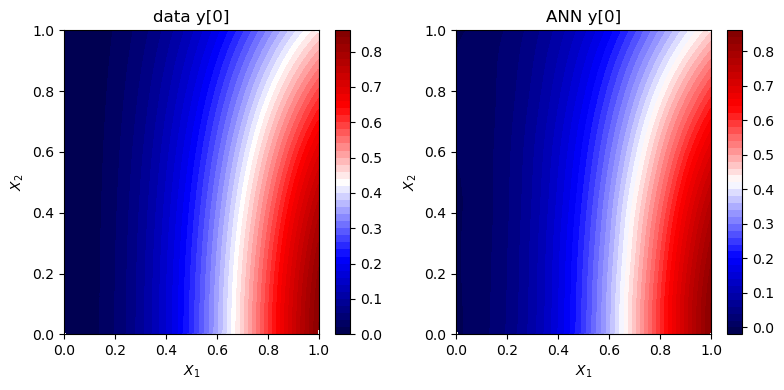

In [7]:
fig = plt.figure(figsize=[8, 4])

ax = fig.add_subplot(121, xlabel=r'$X_1$', ylabel=r'$X_2$', title='data y[0]', xlim=[0,1], ylim=[0,1])
ct = ax.tricontourf(X[:, 0], X[:, 1], y[:, 0], 50)
plt.colorbar(ct)

ax = fig.add_subplot(122, xlabel=r'$X_1$', ylabel=r'$X_2$', title='ANN y[0]', xlim=[0,1], ylim=[0,1])
ct = ax.tricontourf(X[:, 0], X[:, 1], predictions[:, 0], 50)
plt.colorbar(ct)

plt.tight_layout()

### User defined mean absolute loss

Now, let's say we wish to use the following (mean absolute) loss instead, which is not implemented:

\begin{align}
L = \frac{1}{n_{out}}\sum|y_j - {\bf h}_j|
\end{align}

We can define the loss function which returns $L$ and the corresponding loss gradient per output neuron per mini batch sample:

\begin{align}
\frac{\partial L}{\partial {\bf h}_j} = -\frac{1}{n_{out}}\mathrm{sign}({\bf y} - H)
\end{align}

The `sign` function acts elementwise.

This function **needs to have the arguments `(h, y)`, in this order**.

In [8]:
def user_defined_loss(h, y):
    """
    User defined mean absolute loss L = sum |y_j - h_j| / n_out.

    Parameters
    ----------
    h : array, shape (n_out, batch_size)
        The minibatch ANN prediction of y.
    y : array, shape (n_out, batch_size)
        The minibatch training data.

    Returns
    -------
    L_i : array, shape (n_out, batch_size)
        Elementwise loss function values.
    grad_L : array, shape (n_out, batch_size)
        Elementwise loss function gradient values.

    """

    loss = np.sum(np.abs(y - h), axis=0) / y.shape[0]
    dloss_dh = -np.sign(y - h) / y.shape[0]

    return loss, dloss_dh

We redefine the ANN, and just pass the user-defined loss function as `loss=user_defined_loss`

In [9]:
ANN = es.methods.ANN_Surrogate()

# number of mini batch iterations
n_iter = 5000

# train the ANN
ANN.train(X, y, n_iter,
          loss = user_defined_loss,
          n_neurons = 100, n_layers = 3, 
          batch_size=32)

Creating ANN_Surrogate Object
Creating Feature Engineering object
Using  10000/10000 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 2
Loss function = <function user_defined_loss at 0x7f027237ab80>
Number of neurons per hidden layer = 100
Number of output neurons = 2
Activation = ['linear', 'tanh', 'tanh', 'linear']
This neural network has 10602 weights.
Training Artificial Neural Network...


  2%|███                                                                                                                                                                 | 93/5000 [00:00<00:05, 927.67it/s]

 loss = 0.7908


 22%|███████████████████████████████████▌                                                                                                                              | 1099/5000 [00:01<00:03, 981.25it/s]

 loss = 0.0102


 42%|████████████████████████████████████████████████████████████████████▌                                                                                             | 2116/5000 [00:02<00:02, 995.03it/s]

 loss = 0.0086


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 3139/5000 [00:03<00:01, 980.70it/s]

 loss = 0.0111


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4144/5000 [00:04<00:00, 975.11it/s]

 loss = 0.0107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 990.40it/s]


Make predictions at training data

In [10]:
predictions = np.zeros([X.shape[0], n_out])
for i, x in enumerate(X):
    predictions[i] = ANN.predict(x)

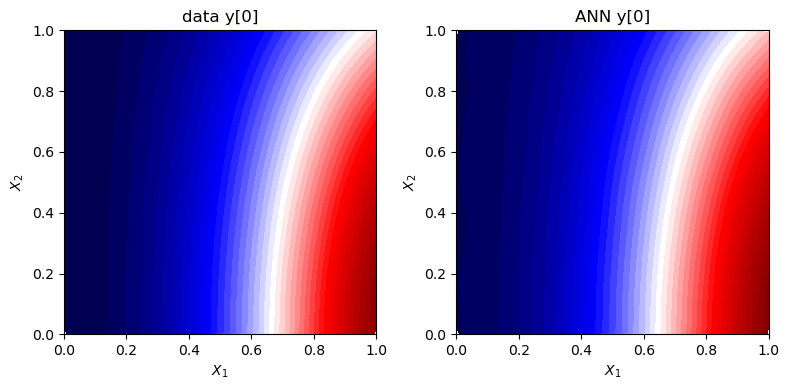

In [11]:
fig = plt.figure(figsize=[8,4])

ax = fig.add_subplot(121, xlabel=r'$X_1$', ylabel=r'$X_2$', title='data y[0]', xlim=[0,1], ylim=[0,1])
ax.tricontourf(X[:, 0], X[:, 1], y[:, 0], 50)

ax = fig.add_subplot(122, xlabel=r'$X_1$', ylabel=r'$X_2$', title='ANN y[0]', xlim=[0,1], ylim=[0,1])
ax.tricontourf(X[:, 0], X[:, 1], predictions[:, 0], 50)

plt.tight_layout()

### Finite difference verification of the loss gradient

The contourplots above should look similar, indicating that our new loss function is working properly. We can perform an addition verification by comparing the loss gradient $\partial L/\partial x_i$ for all input neurons $x_i$ with a finite difference approximation of this gradient;

In [12]:
analysis = es.analysis.ANN_analysis(ANN)
analysis.finite_difference_gradient_check(X, y)

Creating ANN_analysis object
----------------------------------------------------------
Input neuron x0
Analytic loss gradient dL/dx0 = -1.5237e-01
Finite difference approximation of dL/dx0 = -1.5237e-01
Relative error = 0.0000%
----------------------------------------------------------
Input neuron x1
Analytic loss gradient dL/dx1 = 4.9804e-01
Finite difference approximation of dL/dx1 = 4.9804e-01
Relative error = 0.0000%
----------------------------------------------------------
